In [2]:
import os
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import warnings
from tqdm import tqdm_notebook as tqdm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import utils
from constants import DATA_DIR
warnings.filterwarnings('ignore')

Baseline and weighted data with 9 features: Select best weighting

In [5]:
weights = ['base','sqrt','linear','quad']
seasons = ['2016-17','2017-18','2018-19','2019-20']

for weight in tqdm(weights):
    df = pd.DataFrame()
    mean = []
    for season in seasons:
        df1 = pd.read_csv(os.path.join(DATA_DIR,'Weighted',weight,season+'.csv'))
        df = df.append(df1)
    df.fillna(0, inplace=True)
    columns = ['G','FG%','FT%','3P','PTS','TRB','AST','STL','TOV']
    X = df.loc[:, columns]
    y = df['VALUE']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=None)
    cv = RepeatedKFold(n_splits=2, n_repeats=1000)
    reg = LinearRegression()
    scores = cross_val_score(reg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv)
    model = reg.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mean.append(np.mean(scores))
    print(weight)
    print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    print(mae(y_test, y_pred))
    print(mse(y_test, y_pred, squared=False))
    print('\n')
    
    #print(sum(mean) / len(mean))

base
Accuracy: -2.876 (0.094)
2.0238647975151243
2.676762901875008


sqrt
Accuracy: -2.749 (0.094)
2.123618540582793
2.762604317009168


linear
Accuracy: -2.722 (0.092)
2.045890413708809
2.615059396935846


quad
Accuracy: -2.632 (0.096)
2.039208205366634
2.633878854974409





Here's where we add more features and cut them down with feature selection

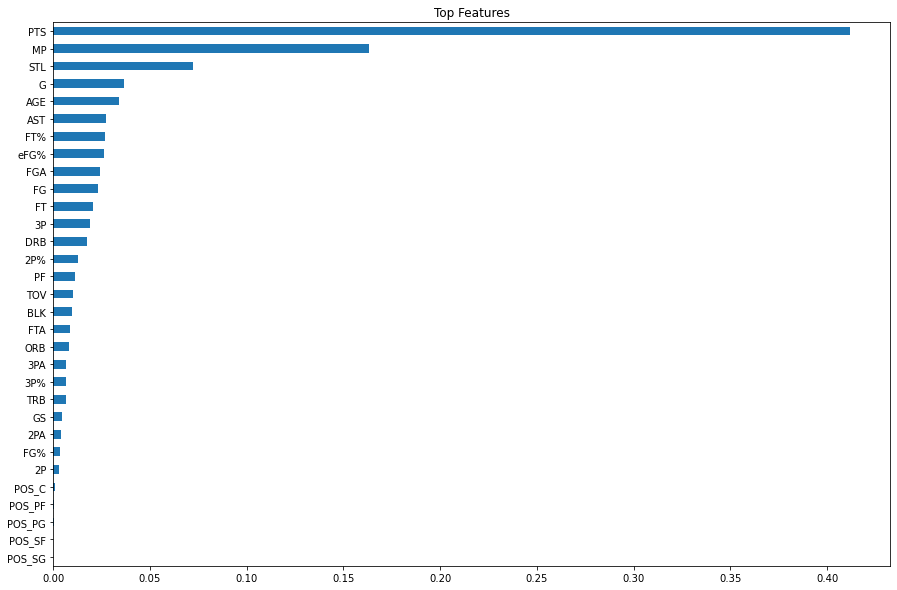

(1083, 32)


In [12]:
#feature selection add more features prior to this?
weight = 'quad'
df = pd.DataFrame()
for season in seasons:
    df1 = pd.read_csv(os.path.join(DATA_DIR,'Weighted',weight,season+'.csv'))
    df = df.append(df1)
df.drop(columns=['PLAYER','TEAM','SEASON'], inplace=True)
df = pd.get_dummies(df)
df.fillna(0, inplace=True)
df.to_csv(os.path.join(DATA_DIR,'ABT','abt.csv'), index=False)
X = df.loc[:, df.columns != 'VALUE']
y = df['VALUE']
model = GradientBoostingRegressor()
model.fit(X, y)
column = df.columns.drop(['VALUE'])
top_features = pd.Series(model.feature_importances_, index = column).sort_values()
top_features.plot(kind = "barh", figsize=(15,10) ,title='Top Features')
plt.show()
print(df.shape)

In [13]:
# create ABT
omit_lowest = 5
selected = list(top_features[omit_lowest:].index)
new_abt = df.loc[:,selected]
new_abt['VALUE'] = y
new_abt.to_csv(os.path.join(DATA_DIR,'ABT','data.csv'), index=False)
print(new_abt.shape)

(1083, 27)
